<a href="https://colab.research.google.com/github/dchatterjee/tracking.kalman-filter/blob/main/KalmanFilter_3D_ball_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

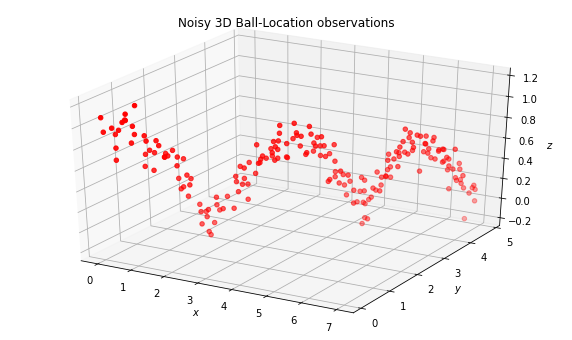

In [2]:
# Time step
dt = 0.01 

# total number of measurements
m = 200 

# initial position of the ball

# positions at start
px= 0.0 
py= 0.0
pz= 1.0

# velocities at start
vx = 5.0 
vy = 3.0 
vz = 0.0

# Drag Resistance Coefficient
c = 0.1 

# Damping
d = 0.9 

# Arrays to store location measurements
Xr=[]
Yr=[]
Zr=[]

# generating dummy data
for i in range(0, m):
    
 # update acceleration (deceleration), velocity, position in x direction
    accx = -c*vx**2 
    vx += accx*dt
    px += vx*dt
 # update acceleration (deceleration), velocity, position in y direction
    accy = -c*vy**2
    vy += accy*dt
    py += vy*dt
 # update acceleration, velocity, position in x direction
    accz = -9.806 + c*vz**2 
    vz += accz*dt
    pz += vz*dt
 # if the object is about to hit the base, 
 # change direction, with damping
    if pz<0.01:
        vz=-vz*d
        pz+=0.02
 # add to the arrays storing locations
    Xr.append(px)
    Yr.append(py)
    Zr.append(pz)


# Add random noise to measurements
# Standard Deviation for noise
sp= 0.1 
Xm = Xr + sp * (np.random.randn(m))
Ym = Yr + sp * (np.random.randn(m))
Zm = Zr + sp * (np.random.randn(m))
# stack the measurements together for ease of later use
measurements = np.vstack((Xm,Ym,Zm))

fig = plt.figure(figsize=(10,6))
Three_dplot = fig.add_subplot(111, projection='3d')
Three_dplot.scatter(Xm, Ym, Zm, c='red')
Three_dplot.set_xlabel('$x$')
Three_dplot.set_ylabel('$y$')
Three_dplot.set_zlabel('$z$')
plt.title('Noisy 3D Ball-Location observations')
plt.show()

In [3]:
# Identity matrix
I = np.eye(9)

# state matrix
x = np.matrix([0.0, 0.0, 1.0, 5.0, 3.0, 0.0, 0.0, 0.0, -9.81]).T

# P matrix
P = 100.0*np.eye(9)

# A matrix
A = np.matrix([[1.0, 0.0, 0.0, dt, 0.0, 0.0, 1/2.0*dt**2, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0, 1/2.0*dt**2, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0, 1/2.0*dt**2],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

# H matrix
H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

# R matrix
r = 1.0
R = np.matrix([[r, 0.0, 0.0],
 [0.0, r, 0.0],
 [0.0, 0.0, r]])

# Q, G matrices
s = 8.8
G = np.matrix([[1/2.0*dt**2],
 [1/2.0*dt**2],
 [1/2.0*dt**2],
 [dt],
 [dt],
 [dt],
 [1.0],
 [1.0],
 [1.0]])
Q = G*G.T*s**2

B = np.matrix([[0.0], #Disturbance Control Matrix 
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0]])

u = 0.0 #Control Input



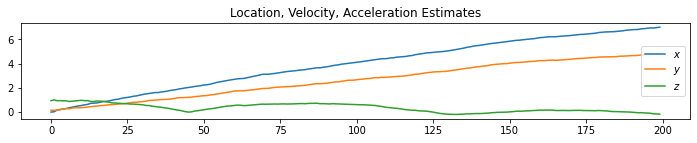

In [4]:
xt = []
yt = []
zt = []
dxt= []
dyt= []
dzt= []
ddxt=[]
ddyt=[]
ddzt=[]
Zx = []
Zy = []
Zz = []
Px = []
Py = []
Pz = []
Pdx= []
Pdy= []
Pdz= []
Pddx=[]
Pddy=[]
Pddz=[]
Kx = []
Ky = []
Kz = []
Kdx= []
Kdy= []
Kdz= []
Kddx=[]
Kddy=[]
Kddz=[]

onFloor = False
for i in range(0, m):
# Model the direction switch, when hitting the plate
    if x[2]<0.02 and not onFloor:
        x[5] = -x[5]
        onFloor=True
# Prediction
# state prediction
    x = A*x + B*u 
# Project the error covariance ahead
    P = A*P*A.T + Q 
# Update
# Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)
# Update the estimate via z
    Z = measurements[:,i].reshape(H.shape[0],1)
    y = Z - (H*x) 
    x = x + (K*y)
# error covariance
    P = (I - (K*H))*P
    
    # Storing results
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    zt.append(float(x[2]))
    dxt.append(float(x[3]))
    dyt.append(float(x[4]))
    dzt.append(float(x[5]))
    ddxt.append(float(x[6]))
    ddyt.append(float(x[7]))
    ddzt.append(float(x[8]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Zz.append(float(Z[2]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pz.append(float(P[2,2]))
    Pdx.append(float(P[3,3]))
    Pdy.append(float(P[4,4]))
    Pdz.append(float(P[5,5]))
    Pddx.append(float(P[6,6]))
    Pddy.append(float(P[7,7]))
    Pddz.append(float(P[8,8]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kz.append(float(K[2,0]))
    Kdx.append(float(K[3,0]))
    Kdy.append(float(K[4,0]))
    Kdz.append(float(K[5,0]))
    Kddx.append(float(K[6,0]))
    Kddy.append(float(K[7,0]))
    Kddz.append(float(K[8,0]))

# Plots
#State Estimates
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.title('Location, Velocity, Acceleration Estimates')
plt.plot(range(len(measurements[0])),xt, label='$x$')
plt.plot(range(len(measurements[0])),yt, label='$y$')
plt.plot(range(len(measurements[0])),zt, label='$z$')
plt.legend(loc='right' )

Text(0.5, 0, 'Step')

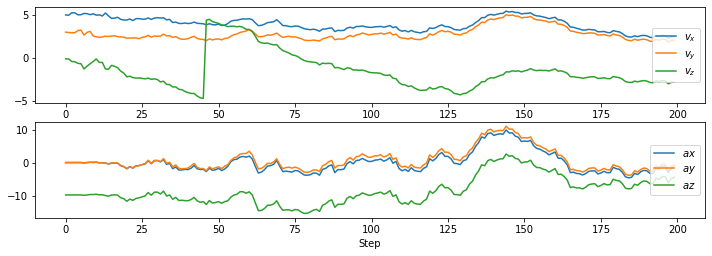

In [5]:
plt.figure(figsize=(12,6))

plt.subplot(312)
plt.plot(range(len(measurements[0])),dxt, label='$v_x$')
plt.plot(range(len(measurements[0])),dyt, label='$v_y$')
plt.plot(range(len(measurements[0])),dzt, label='$v_z$')
plt.legend(loc='right')
plt.subplot(313)
plt.plot(range(len(measurements[0])),ddxt, label='$ax$')
plt.plot(range(len(measurements[0])),ddyt, label='$ay$')
plt.plot(range(len(measurements[0])),ddzt, label='$az$')
plt.legend(loc='right')
plt.xlabel('Step')

Text(0, 0.5, '$y$')

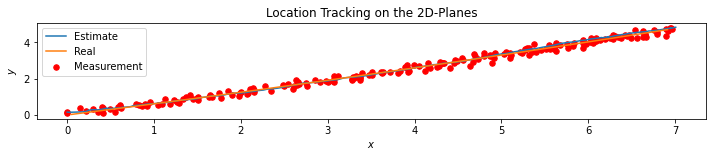

In [6]:
# Location in 2D (z, y)
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.plot(xt,yt, label='Estimate')
plt.scatter(Xm,Ym, label='Measurement', c='red', s=30)
plt.plot(Xr, Yr, label='Real')
plt.title('Location Tracking on the 2D-Planes')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')

Text(0, 0.5, '$z$')

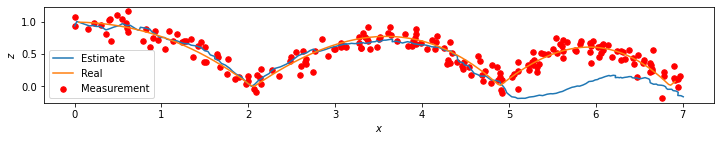

In [7]:
plt.figure(figsize=(12,6))
plt.subplot(312)
plt.plot(xt,zt, label='Estimate')
plt.scatter(Xm,Zm, label='Measurement', c='red', s=30)
plt.plot(Xr, Zr, label='Real')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$z$')

Text(0, 0.5, '$z$')

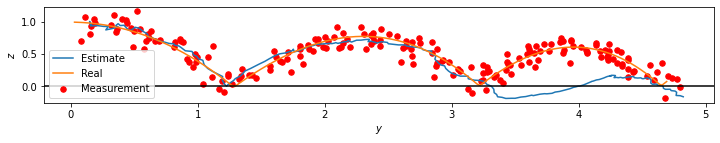

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(313)
plt.plot(yt,zt, label='Estimate')
plt.scatter(Ym,Zm, label='Measurement', c='red', s=30)
plt.plot(Yr, Zr, label='Real')
plt.legend(loc='best')
plt.axhline(0, color='k')
plt.xlabel('$y$')
plt.ylabel('$z$')

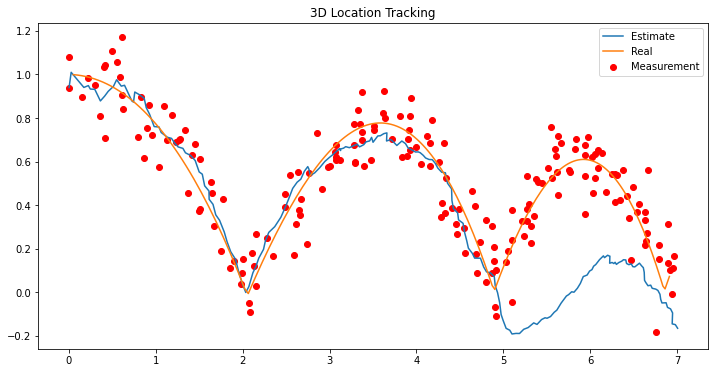

In [9]:
# Position in x/z Plane   
plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
plt.plot(xt,zt, label='Estimate')
plt.scatter(Xm,Zm, label='Measurement', c='red')
plt.plot(Xr,Zr, label='Real')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend()
plt.title('3D Location Tracking')
plt.show()

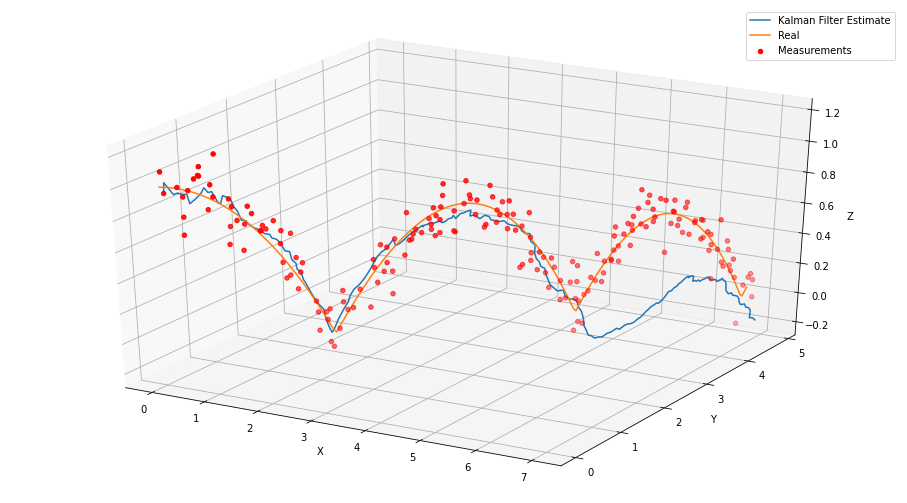

In [10]:
# Location in 3D (X, Y, Z)  
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xt,yt,zt, label='Kalman Filter Estimate')
ax.plot(Xr, Yr, Zr, label='Real')
ax.scatter(Xm, Ym, Zm, c='red', label='Measurements')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()